In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.io import loadmat

# Anomaly detection

In this exercise, you will implement an anomaly detection algorithm to detect
anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server.

In [5]:
data1 = loadmat('data/ex8data1.mat')
data1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [78]:
X = data1['X']
X_val = data1['Xval']
y_val = data1['yval']

In [8]:
print(f'shape of train: {X.shape}')
print(f'shape of val: {X_val.shape}')

shape of train: (307, 2)
shape of val: (307, 2)


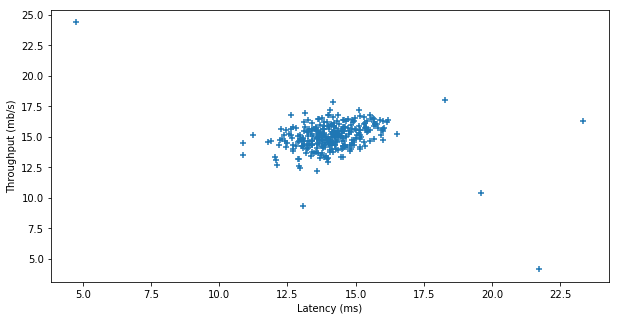

In [16]:
plt.figure(figsize=(10,5))
plt.scatter(X[:,0], X[:,1], marker='+')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)');

### Estimate parameters for the gaussian

In [21]:
mu = np.mean(X, axis=0)
std = np.std(X, axis=0)

In [23]:
print(f'the mean is: {list(mu)}')
print(f'the std is: {list(std)}')

the mean is: [14.112225783945592, 14.99771050813621]
the std is: [1.353747174879607, 1.3075723042450764]


In [67]:
def gaussian_2d(X, mu, std):
    k = mu.size

    sigma2 = std**2
    Sigma2 = np.diag(sigma2)

    X = X - mu
    p = (2 * np.pi) ** (- k / 2) * np.linalg.det(Sigma2) ** (-0.5)\
    * np.exp(-0.5 * np.sum(np.dot(X, np.linalg.pinv(Sigma2)) * X, axis=1))
    
    return p

def visualizeGaussian(X, mu, std, X_val=None):
    
    X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
    Z = gaussian_2d(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, std)
    Z = Z.reshape(X1.shape)
    
    plt.figure(figsize=(10,5))

    plt.scatter(X[:, 0], X[:, 1], marker='+')
    
    
    if np.all(abs(Z) != np.inf):
        plt.contour(X1, X2, Z, levels=10**(np.arange(-20., 1, 3)), zorder=100)

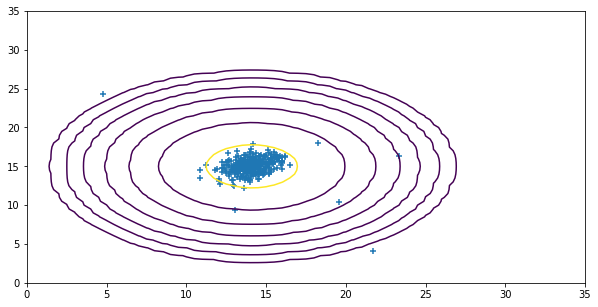

In [68]:
visualizeGaussian(X,mu,std,X_val)

### Selecting the threshold, ε

In [ ]:
tp = None
fp = None
fn = None
precision = tp/(tp+fp)
recall = tp/(tp+fn)
F1_score = (2*precision*recall)/(precision+recall)

In [144]:
def selectThresh(y,p):
    beste = 0
    bestF1 = 0
    F1 = 0
    y = y.ravel()
    es = []
    bfs = []
    
   
    for e in np.linspace(1.01*min(p), max(p), 1000):
        # ====================== YOUR CODE HERE =======================
        res = (p < e)*1
        tp = np.sum((res == 1)*(y == 1))
        fp = np.sum((res == 1) * (y == 0))
        fn = np.sum((res == 0) * (y == 1))
        
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        F1 = (2*precision*recall)/(precision+recall)
        es.append(e)
        bfs.append(F1)
        # =============================================================
        
        if F1 > bestF1:
            print(f'-- F1:{F1}, bestF1:{bestF1}, beste:{e}')
            bestF1 = F1
            beste = e
    history = [es, bfs]
    return beste, bestF1, history

In [118]:
y_val.shape

(307, 1)

In [131]:
y_val.shape

(307, 1)

In [156]:
p = gaussian_2d(X_val,mu,std)
epsilon, bF1, history = selectThresh(y_val,p)

-- F1:0.19999999999999998, bestF1:0, beste:4.558383439613006e-36
-- F1:0.8750000000000001, bestF1:0.19999999999999998, beste:8.999852631901394e-05


Text(0,0.5,'F1 score')

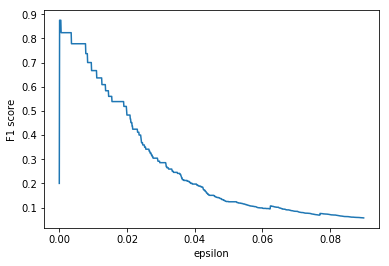

In [150]:

plt.plot(history[0], history[1])
plt.xlabel('epsilon')
plt.ylabel('F1 score')

In [157]:
pred_anom = ((p < epsilon)*1 == y_val.ravel())*1
pred = (p < epsilon)*1

validation anomalies

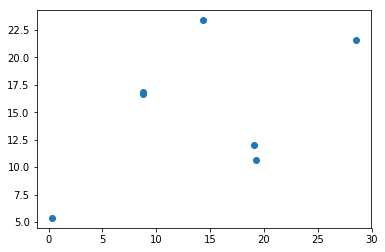

In [161]:
plt.scatter(X_val[pred == 1][:,0],X_val[pred == 1][:,1])

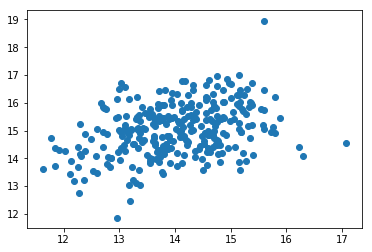

In [160]:
plt.scatter(X_val[pred == 0][:,0],X_val[pred == 0][:,1])

# Recommender System

In [165]:
data2 = loadmat('data/ex8_movies.mat')

In [167]:
data2.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

In [168]:
Y = data2['Y']
R = data2['R']

In [170]:
Y

array([[5, 4, 0, ..., 5, 0, 0],
       [3, 0, 0, ..., 0, 0, 5],
       [4, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [172]:
R

array([[1, 1, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Computational graph

In [208]:
tf.reset_default_graph()

u = Y.shape[1] 
m = Y.shape[0]
k = 3

lmd = 0.001

ratings_matrix = tf.constant(Y, name='ratings_matrix', dtype=tf.float32)
indicator_matrix = tf.constant(R, name='indicator_matrix', dtype=tf.float32)

movie_features = tf.Variable(tf.truncated_normal((m,k), stddev=0.1), name='f' )
user_parameters = tf.Variable(tf.truncated_normal((u,k), stddev=0.1), name='p')

pred_ratings = tf.matmul(movie_features, user_parameters, transpose_b=True)

cost = (1/2)*tf.reduce_sum(tf.square(pred_ratings - ratings_matrix) * indicator_matrix) + lmd/2*tf.reduce_sum((tf.square(user_parameters))) + lmd/2 * tf.reduce_sum((tf.square(movie_features)))

optimize = tf.train.AdamOptimizer().minimize(cost)



Start session

In [209]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [211]:
for i in range(1000):
    c, _, preds = sess.run([cost, optimize, pred_ratings])
    #print(c)